Wine Profile Modeling K-Means and classification prediciton 

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sedwards\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
import re,string
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS
from sklearn.feature_extraction import text


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import numpy as np

C:\Users\sedwards\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\sedwards\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
path=r'''C:\Users\sedwards\OneDrive - Constellation Brands\Documents\Northwestern\PREDICT 453\Final project'''
os.chdir(path)

 path=r'''C:\Users\syurasek\OneDrive - Constellation Brands\Documents\Northwestern\PREDICT 453\Final project'''
os.chdir(path)

In [6]:
wine_data=pd.read_csv('wine_data.csv')

In [7]:
###############################################################################
#   EDA
###############################################################################

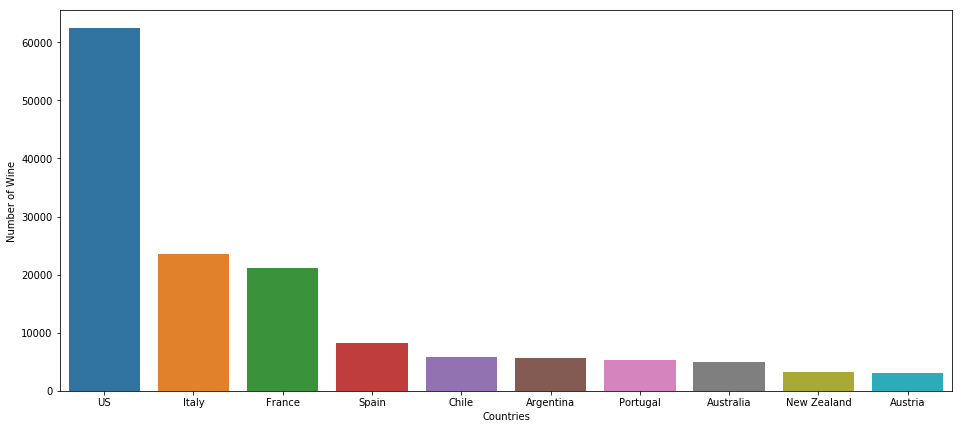

In [8]:
plt.figure(figsize=(16,7))
sns.barplot(x=wine_data.country.value_counts()[:10].index, y=wine_data.country.value_counts()[:10].values)
plt.xlabel("Countries")
plt.ylabel("Number of Wine")
plt.show()

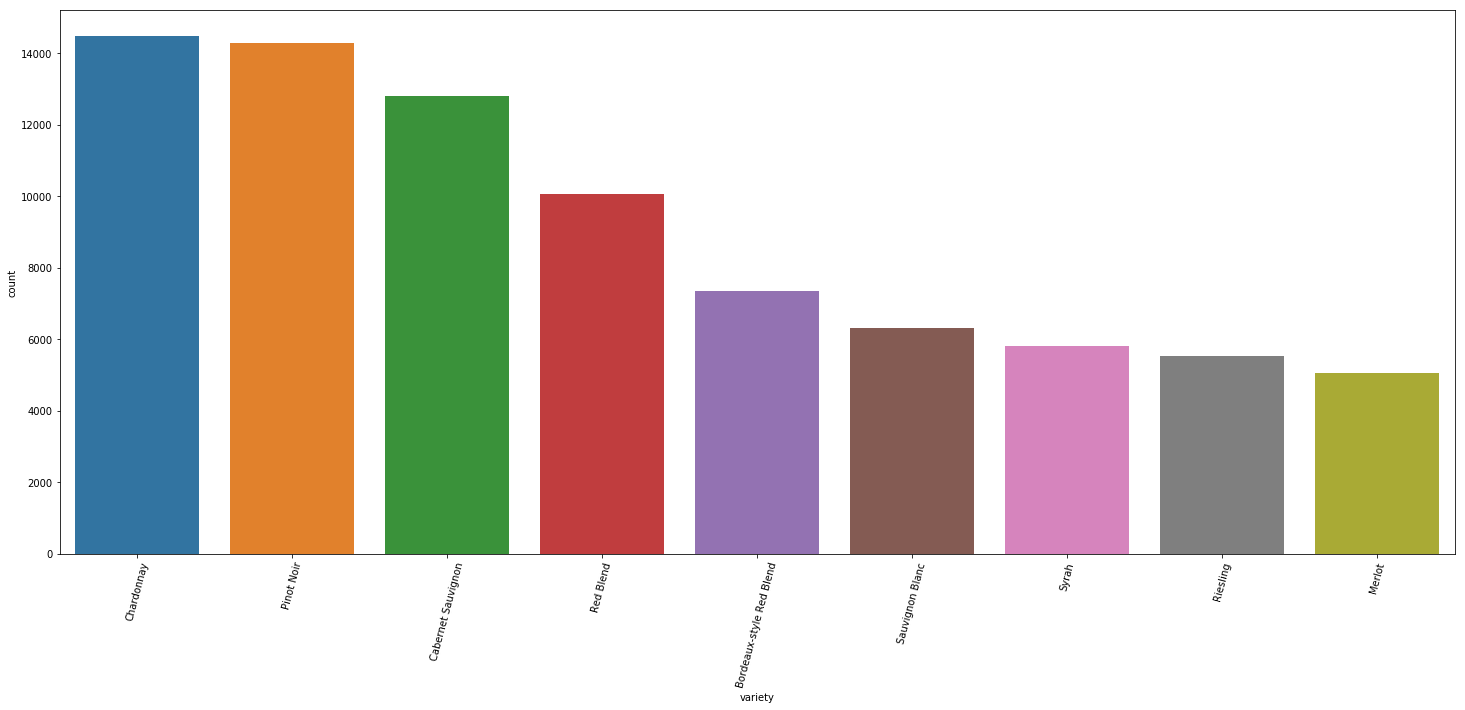

In [9]:
variety_df = wine_data.groupby('variety').filter(lambda x: len(x) > 4000)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 75)
plt.show()

In [10]:
variety_df['variety'].unique()

array(['Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Syrah', 'Red Blend', 'Riesling',
       'Bordeaux-style Red Blend', 'Merlot'], dtype=object)

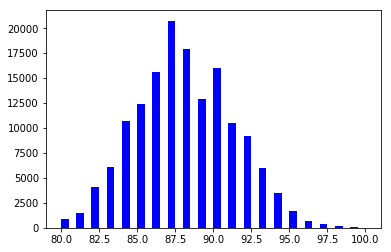

In [11]:
wine_data['points'].hist(grid = False, bins = 40,color = 'blue')

In [12]:
wine_data['points'].describe()

count    150930.000000
mean         87.888418
std           3.222392
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

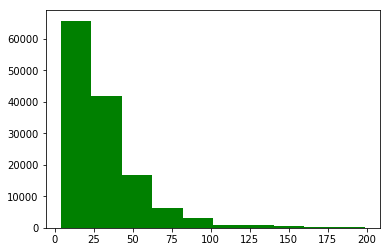

In [13]:
price_max = wine_data[wine_data['price'] < 200]['price']
price_max.hist(grid = False, color = 'green')

In [14]:
price_max.describe()

count    136368.000000
mean         31.272755
std          23.660380
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max         199.000000
Name: price, dtype: float64

In [15]:
dp = wine_data.assign(description_length = wine_data['description'].apply(len))
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 12 columns):
Unnamed: 0            150930 non-null int64
country               150925 non-null object
description           150930 non-null object
designation           105195 non-null object
points                150930 non-null int64
price                 137235 non-null float64
province              150925 non-null object
region_1              125870 non-null object
region_2              60953 non-null object
variety               150930 non-null object
winery                150930 non-null object
description_length    150930 non-null int64
dtypes: float64(1), int64(3), object(8)
memory usage: 13.8+ MB


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_length
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,355
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,318
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,280
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,386
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,376


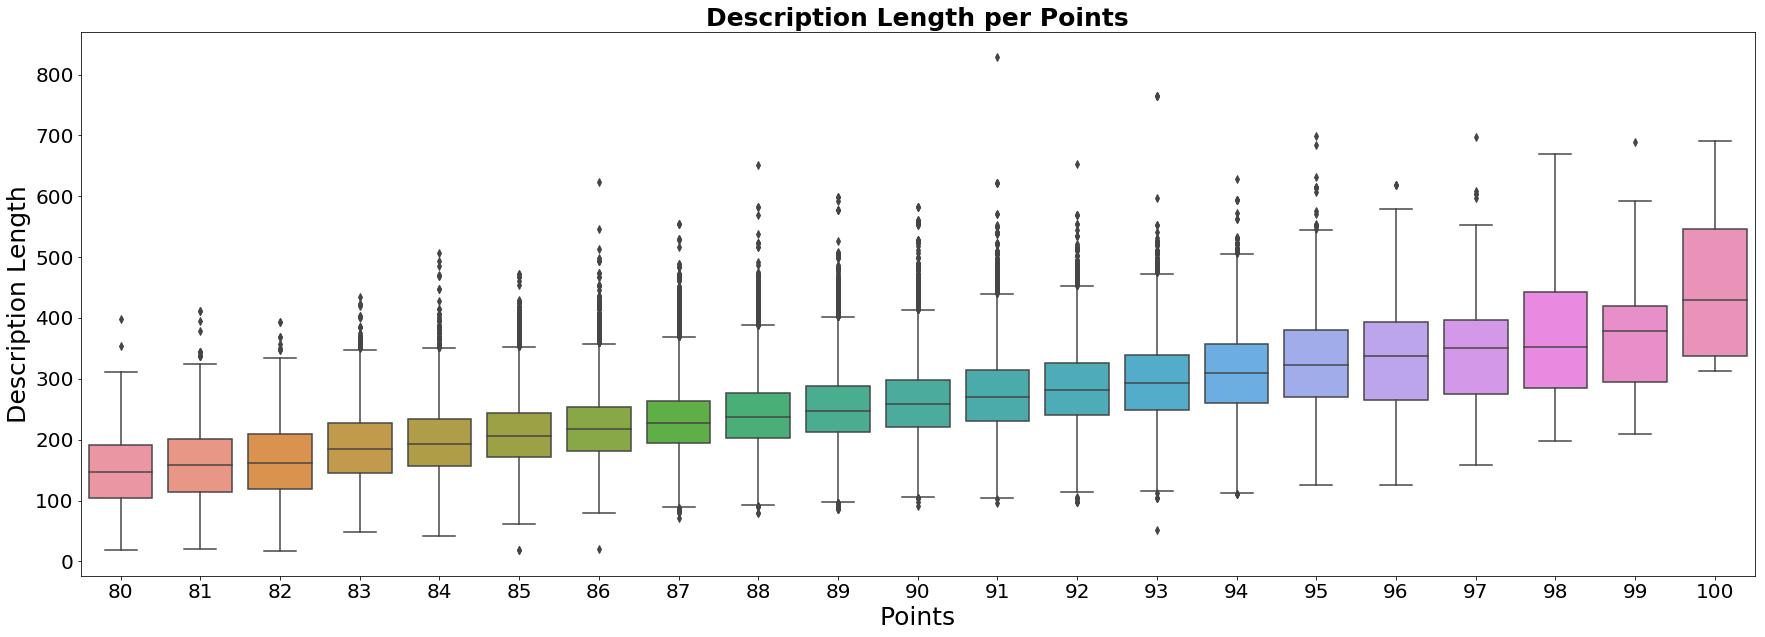

In [16]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

In [17]:
##reference https://www.kaggle.com/bhaargavi/wine-reviews-classification-using-nlp-and-ml
wine = wine_data.dropna(subset = ['points' , 'price'])
df_wine = wine[['country', 'description', 'points', 'price', 'variety']]
df_wine = df_wine.sample(frac = 0.20)
print(df_wine.shape)
df_wine.head()

(27447, 5)


,country,description,points,price,variety
135217,US,"Smells vegetal and cardboardy, tastes thin and...",80,10.0,Merlot
45651,France,"Poised between a rich, soft Pinot Noir and one...",92,75.0,Pinot Noir
57107,Greece,This blend of Merlot and native grape Xinomavr...,88,26.0,Red Blend
2848,US,"This well-aged wine has a slightly earthy, new...",89,25.0,Syrah
143752,US,"Impressive for the price, in fact a supervalue...",85,8.0,Merlot


In [18]:
df_wine.loc[(df_wine['points'] > 0) & (df_wine['points'] <=84), 'wine_quality'] = 'Average'
df_wine.loc[(df_wine['points'] > 84) & (df_wine['points'] <=88), 'wine_quality'] = 'Good'
df_wine.loc[(df_wine['points'] > 88) & (df_wine['points'] <=92), 'wine_quality'] = 'Very Good'
df_wine.loc[(df_wine['points'] > 92) & (df_wine['points'] <=96), 'wine_quality'] = 'Great'
df_wine.loc[(df_wine['points'] > 96) & (df_wine['points'] <=100), 'wine_quality'] = 'Excellent'
df_wine = df_wine[df_wine['wine_quality'].apply(lambda x: type(x) == str)]

In [19]:
df_wine.loc[(df_wine['points'] > 0) & (df_wine['points'] <=84), 'wine_rank'] = '1'
df_wine.loc[(df_wine['points'] > 84) & (df_wine['points'] <=88), 'wine_rank'] = '2'
df_wine.loc[(df_wine['points'] > 88) & (df_wine['points'] <=92), 'wine_rank'] = '3'
df_wine.loc[(df_wine['points'] > 92) & (df_wine['points'] <=96), 'wine_rank'] = '4'
df_wine.loc[(df_wine['points'] > 96) & (df_wine['points'] <=100), 'wine_rank'] = '5'
df_wine = df_wine[df_wine['wine_rank'].apply(lambda x: type(x) == str)]

In [20]:
df_wine.loc[(df_wine['price'] > 0) & (df_wine['price'] <=20) , 'price_val'] = '0-20'
df_wine.loc[(df_wine['price'] > 20) & (df_wine['price'] <=30) , 'price_val'] = '20-30'
df_wine.loc[(df_wine['price'] > 30) & (df_wine['price'] <=50) , 'price_val'] = '30-50'
df_wine.loc[(df_wine['price'] > 50) & (df_wine['price'] <=100) , 'price_val'] = '50-100'
df_wine.loc[df_wine['price'] > 100  , 'price_val'] = 'Above 100'

In [21]:
df_wine.head(20)

,country,description,points,price,variety,wine_quality,wine_rank,price_val
135217,US,"Smells vegetal and cardboardy, tastes thin and...",80,10.0,Merlot,Average,1,0-20
45651,France,"Poised between a rich, soft Pinot Noir and one...",92,75.0,Pinot Noir,Very Good,3,50-100
57107,Greece,This blend of Merlot and native grape Xinomavr...,88,26.0,Red Blend,Good,2,20-30
2848,US,"This well-aged wine has a slightly earthy, new...",89,25.0,Syrah,Very Good,3,20-30
143752,US,"Impressive for the price, in fact a supervalue...",85,8.0,Merlot,Good,2,0-20
123980,Italy,"Serious and multifaceted, with peppery black f...",92,47.0,Barbera,Very Good,3,30-50
120831,France,"The top white wine from Chantegrive, this is a...",92,23.0,Bordeaux-style White Blend,Very Good,3,20-30
30026,Portugal,"This is a finely integrated, rich wine that sh...",90,16.0,Portuguese Red,Very Good,3,0-20
27121,Austria,"Initially smooth and rich, this slowly reveals...",91,42.0,Grüner Veltliner,Very Good,3,30-50
6563,Italy,From one of the most esteemed vineyards in the...,89,195.0,Nebbiolo,Very Good,3,Above 100


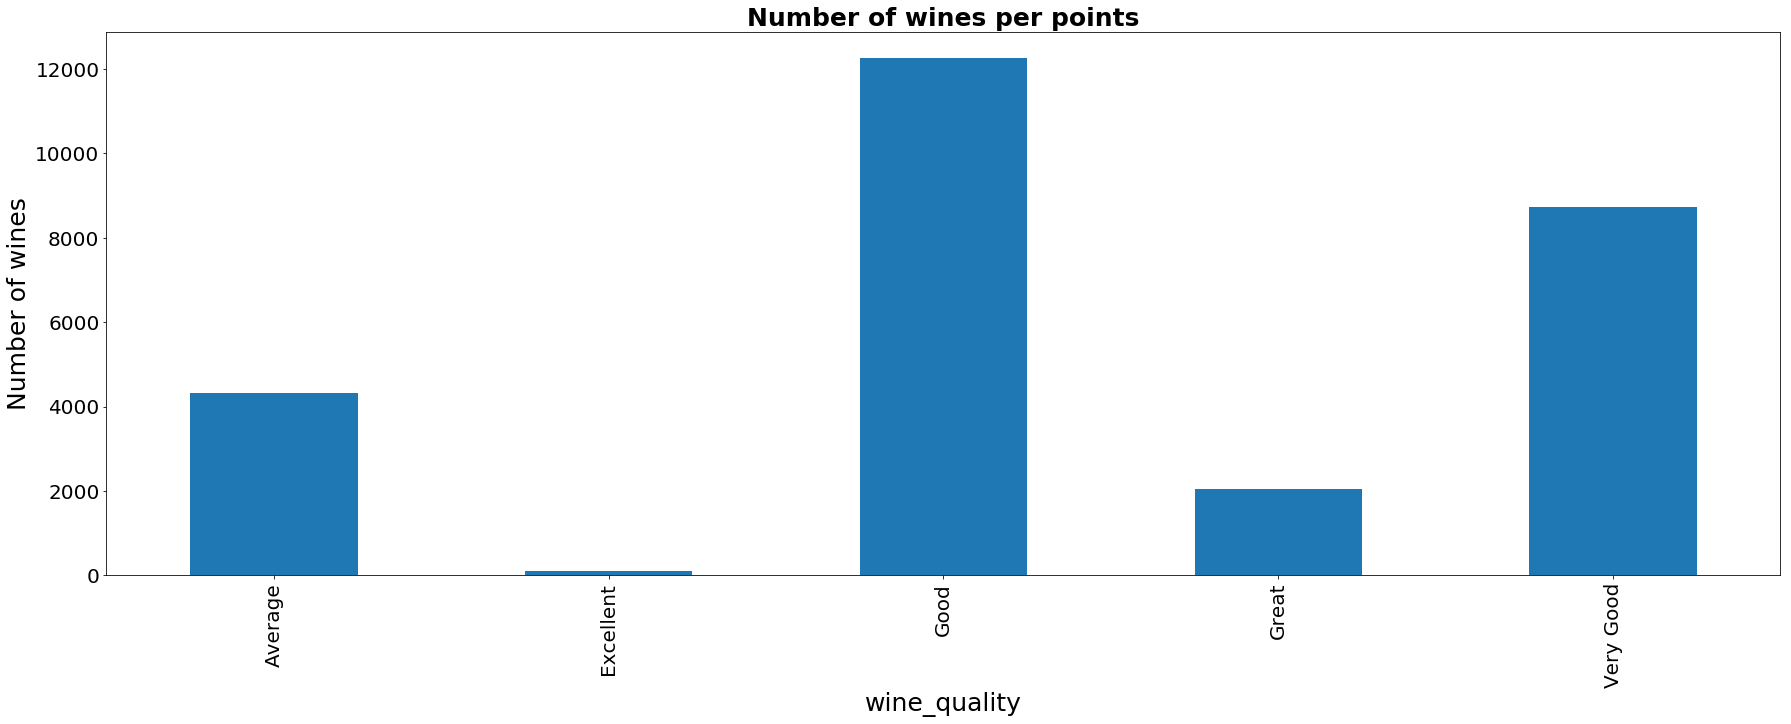

In [22]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
df_wine.groupby(['wine_quality']).count()['description'].plot(ax=ax, kind='bar')

In [23]:
###############################################################################
#   Functions to data process
###############################################################################

In [24]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 5]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

In [25]:
###############################################################################
#   Functions to label encoding
###############################################################################

In [26]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [27]:
#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(df_wine)):
    temp_text=df_wine['variety'].iloc[i]
    titles.append(temp_text)

#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(df_wine)):
    temp_text=df_wine['description'].iloc[i]
    text_body.append(temp_text)

In [28]:
#Note: the text_body is the unprocessed list of documents read directly form 
#the csv.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.

In [29]:
#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
#Note: We stitched the processed text together so the TFIDF vectorizer can work.
#Final section of code has 3 lists used.  2 of which are used for further processing.
#(1) text_body - unused, (2) processed_text (used in W2V), 
#(3) final_processed_text (used in TFIDF), and (4) DSI titles (used in TFIDF Matrix)

In [30]:
###############################################################################
### Sklearn TFIDF 
###############################################################################

#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,1))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [31]:
TFIDF_matrix

<27447x16876 sparse matrix of type '<class 'numpy.float64'>'
	with 357650 stored elements in Compressed Sparse Row format>

In [32]:
matrix.head(10)

,abacela,abacelas,abadal,abadia,abandon,abandoned,abandoning,abbacchio,abbaye,abbinare,...,zinsyrah,zlahtina,zonins,zucchini,zweigelt,zweigelts,àmaurice,élevage,òsaigneeó,öküzgözü
Merlot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pinot Noir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Red Blend,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Syrah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Merlot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Barbera,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bordeaux-style White Blend,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Portuguese Red,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grüner Veltliner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nebbiolo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
###############################################################################
### Explore TFIDF Values
###############################################################################

average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)


#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]


#can export matrix to csv and explore further if necessary

In [34]:
outlier_list.head(20)

,TFIDF
ability,0.000290
abound,0.000468
abrasive,0.000175
absolutely,0.000595
abundance,0.000287
abundant,0.000460
acacia,0.000456
accent,0.001766
accented,0.003334
accenting,0.000554


In [35]:
print(outlier_list.describe())

             TFIDF
count  2487.000000
mean      0.001127
std       0.002341
min       0.000175
25%       0.000264
50%       0.000458
75%       0.001026
max       0.046758


In [36]:
###############################################################################
### Doc2Vec
###############################################################################
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)
doc2vec_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,title
0,3.274246e-04,0.002781,-0.000425,-0.003768,0.003284,0.002832,0.003524,0.003868,-0.001997,-0.004335,...,-0.003261,-0.000270,-0.002147,0.002191,-0.003695,-0.003673,-0.001186,0.002718,0.000707,Merlot
1,3.111244e-03,0.000402,-0.000740,-0.004097,0.002188,-0.000626,-0.000939,0.002051,-0.002049,-0.000473,...,-0.003929,-0.002173,-0.002009,0.002391,-0.000003,0.000124,0.001677,-0.000883,-0.002626,Pinot Noir
2,3.629835e-03,-0.004125,0.001780,0.003153,-0.003316,-0.001556,-0.000997,-0.000942,0.004621,-0.000406,...,0.000918,-0.004938,-0.004508,-0.000256,0.004031,-0.002774,-0.004522,-0.004322,-0.002997,Red Blend
3,-5.587352e-05,-0.002230,-0.002060,0.004634,0.003323,-0.003675,-0.002577,0.003901,-0.004574,-0.001867,...,-0.002433,0.002660,0.000419,-0.003592,-0.004691,0.001944,0.000638,0.004112,-0.003570,Syrah
4,-7.329240e-04,0.001019,0.002193,-0.002246,-0.001116,-0.000488,0.001757,0.003455,0.004230,0.003676,...,0.002268,0.002675,-0.002459,-0.000666,0.000152,-0.000508,-0.002499,0.003664,0.001232,Merlot
5,-1.987116e-03,-0.000559,-0.001557,-0.002052,-0.003971,0.003977,-0.000521,0.004195,-0.002585,0.001814,...,-0.004693,-0.003965,-0.000263,-0.003213,0.001798,-0.003992,-0.003783,0.003576,0.003384,Barbera
6,-1.151709e-03,0.004743,-0.004691,-0.003469,0.001057,-0.004667,-0.001196,0.000463,-0.004425,-0.001935,...,-0.000572,0.003927,0.003784,0.002115,-0.004363,0.000309,0.001115,-0.003845,0.001594,Bordeaux-style White Blend
7,-3.005671e-03,0.003929,-0.000659,0.003528,0.004148,-0.001013,-0.004131,-0.000934,-0.000397,-0.000423,...,-0.000697,-0.000376,0.004834,0.002691,0.003904,-0.002106,-0.003363,-0.004781,0.004529,Portuguese Red
8,-2.590132e-03,-0.003075,-0.002813,-0.003315,-0.003381,0.001000,-0.004439,-0.001659,-0.004315,-0.003369,...,-0.003793,-0.001444,-0.001426,0.002184,-0.000040,0.003163,0.002167,-0.001290,0.004701,Grüner Veltliner
9,5.630714e-04,-0.002051,-0.002568,0.003656,0.004909,-0.000805,0.000481,0.001120,-0.001332,-0.003381,...,-0.003191,-0.004377,-0.003623,0.001886,-0.001685,-0.000921,0.000921,-0.001523,-0.002217,Nebbiolo


In [37]:
###############################################################################
### Gensim Word2vec 
###############################################################################

#Note, there are opportunities to use the word2vec matrix to determine words 
#which are similar.  Similar words can be used to create equivalent classes.  
#k-means is not used to group individual words using the Word2Vec output.

#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()


#the following section runs applies the k-means algorithm on the TFIDF matrix.

In [38]:
###############################################################################
### K Means Clustering - TFIDF
###############################################################################

#### K=9 Evaluation 

k=9
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 herbal
 flavors
 finish
 aromas
 palate
 earthy
 cherry
 tannins
 slightly
 tannic
Cluster 0 titles: Malbec-Tannat, Cabernet Sauvignon, Chenin Blanc, Syrah, Pinot Noir, Tempranillo-Shiraz, Sauvignon Blanc, Cabernet Sauvignon, Merlot, Tempranillo, Carmenère, Cabernet Sauvignon, Pinot Noir, Pinot Noir, Malbec, Pinot Noir, Tempranillo, Malbec, Pinot Noir, Cabernet Sauvignon, Merlot, Syrah, Carmenère, Sauvignon Blanc, Chardonnay, White Blend, Cabernet Sauvignon, Bordeaux-style White Blend, Pinot Noir, Tempranillo Blend, Sauvignon Blanc, Pinot Noir, White Blend, Tempranillo, Syrah, Malbec-Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Sauvignon Blanc, Cabernet Sauvignon, Cabernet Sauvignon-Syrah, Shiraz, Carmenère-Syrah, Agiorgitiko, Red Blend, Syrah, Carmenère, Riesling, Tempranillo Blend, Riesling, Cabernet Sauvignon, White Blend, Chardonnay, Malbec, Malbec, Pinot Gris, Malbec, Merlot, Pinot Noir, Cabernet Franc, Carmenère, Grüner Veltliner,

Cluster 1 titles: Red Blend, Cabernet Sauvignon-Malbec, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Cabernet Blend, Bordeaux-style Red Blend, Red Blend, Cabernet Sauvignon, Red Blend, Malbec, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Red Blend, Bordeaux-style Red Blend, Rosé, Cabernet Sauvignon, Petite Sirah, Red Blend, Red Blend, Cabernet Sauvignon, Red Blend, Red Blend, Red Blend, Cabernet Sauvignon, Claret, Red Blend, Cabernet Blend, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Red Blend, Bordeaux-style Red Blend, Malbec-Cabernet Sauvignon, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Cabernet Franc, Red Blend, Red Blend, Red Blend, Sauvignon Blanc, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Sangiovese, Cabernet Sauvignon, Red Blend, Red Blend, Red Blend, Red Blend, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Cabernet Franc, Tempranillo Blend, Cabernet Sauvignon-Syr

Cluster 2 titles: Chardonnay, Riesling, Chardonnay, Sauvignon Blanc, Chardonnay, Sauvignon Blanc, Chardonnay, Chardonnay, Chardonnay, Muscat, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Portuguese White, Chardonnay, Sparkling Blend, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Sauvignon Blanc, Sauvignon Blanc, Moscato, Chardonnay-Semillon, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Riesling, Viognier, Roussanne, Chardonnay, Chardonnay, Chardonnay, Chardonnay, White Blend, Chardonnay, Chardonnay, Chardonnay, Sauvignon Blanc, Pinot Blanc, Sauvignon Blanc, Chardonnay, White Blend, Chardonnay, White Blend, Chardonnay, Portuguese White, White Riesling, White Blend, Pinot Grigio, Chardonnay, Sauvignon Blanc, Chardonnay, Chardonnay, Chardonnay, Pinot Grigio, Chardonnay, Chardonnay, Sparkling Blend, Chardonnay, Chardonnay, Pinot Gris, Sauvignon Blanc, Chardonnay, Sauvignon Blanc, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Pinot Grigio, Chard

Cluster 3 titles: Red Blend, Sparkling Blend, Chardonnay, Pinot Noir, Riesling, Cabernet Sauvignon, Kerner, Portuguese White, Syrah, Chardonnay, Riesling, Cabernet Sauvignon, Cabernet Sauvignon, Roussanne, Chardonnay, Zinfandel, Malbec, Chardonnay, Pinot Noir, Chardonnay, Zinfandel, Riesling, Prosecco, Tempranillo, Red Blend, Chardonnay, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Malbec, Merlot, Shiraz, Verdejo, Cabernet Sauvignon, Riesling, Port, Sparkling Blend, Sangiovese, Syrah, Grenache, Marsanne, Pinot Grigio, Rhône-style Red Blend, Zinfandel, Sangiovese, Pinot Noir, Syrah, Malbec, Nero d'Avola, Tempranillo, Sparkling Blend, Cabernet Sauvignon, Zinfandel, Chardonnay, Gewürztraminer, Arinto, Pinot Noir, Shiraz, Greco, Chardonnay, Malbec, Tinto del Pais, Rhône-style Red Blend, Chardonnay, Merlot, Zinfandel, Chardonnay, Red Blend, Pinot Grigio, Pinot Gris, Carmenère, Pinot Grigio, Pinot Grigio, Tempranillo, Chardonnay, Riesling, Pinot Noir, Pinot Noir, Pinot Noir, Corvina, Rondinel

 Cabernet Sauvignon-Syrah, Shiraz, Sauvignon Blanc, Nebbiolo, Syrah, Portuguese Red, Red Blend, Champagne Blend, Pinot Noir, Riesling, Cabernet Sauvignon-Shiraz, Sangiovese, Verdicchio, Pinot Noir, Sauvignon Blanc, Riesling, Sauvignon Blanc, Zinfandel, Zinfandel, Cabernet Sauvignon, Insolia, Pinot Noir, Sparkling Blend, Pinot Noir, Sauvignon Blanc, Cabernet Sauvignon, Sauvignon Blanc, Red Blend, Cabernet Sauvignon, Nebbiolo, Pinot Noir, Chardonnay, Pinot Gris, Pinot Blanc, Gewürztraminer, Barbera, Chardonnay, Riesling, Rhône-style Red Blend, Moscadello, Chardonnay, Muscat Canelli, Cabernet Sauvignon, Syrah, Riesling, Greco, Nebbiolo, Riesling, Red Blend, Chardonnay, Riesling, Zinfandel, Merlot, Tempranillo, Vilana, Cabernet Sauvignon, Sauvignon Blanc, Merlot, Roussanne, Syrah, Rhône-style White Blend, Cabernet Sauvignon, Pinot Noir, Albariño, Cabernet Sauvignon, Sauvignon Blanc, White Blend, Portuguese White, White Blend, Malbec, Bordeaux-style Red Blend, Petite Verdot, Red Blend, Zinf

 Red Blend, Chardonnay, Nebbiolo, Garganega, Riesling, Merlot, Pinot Grigio, Syrah, Syrah, Riesling, Zinfandel, Riesling, Chardonnay, Malbec, Bordeaux-style White Blend, Zinfandel, Tempranillo, Zinfandel, Portuguese Red, Malbec, Chardonnay, Corvina, Rondinella, Molinara, Shiraz-Cabernet Sauvignon, Chardonnay, Riesling, White Blend, Cabernet Sauvignon, Chenin Blanc, Corvina, Rondinella, Molinara, Cabernet Blend, Chardonnay, Pinot Gris, Rhône-style Red Blend, Sangiovese, Aglianico, Zinfandel, Red Blend, Pinot Noir, Friulano, Cabernet Franc, Merlot, Cabernet Sauvignon, Chardonnay, Bordeaux-style Red Blend, Chardonnay, Semillon-Sauvignon Blanc, Merlot, Cabernet Sauvignon, Chardonnay, Chardonnay, Tempranillo Blend, Chardonnay-Viognier, Chardonnay, Port, Glera, Chardonnay, Bordeaux-style White Blend, Zinfandel, Pinot Gris, Nebbiolo, Garnacha, Chardonnay, Malbec, Merlot, Sauvignon Blanc, Chenin Blanc, Sangiovese Grosso, Sangiovese, Merlot, Portuguese Red, Chardonnay, Malbec, Cabernet Sauvigno

Cluster 4 titles: Chardonnay, Viognier, Riesling, Red Blend, Chardonnay, Chardonnay, Sauvignon Blanc, Chardonnay, Tempranillo, White Blend, Cabernet Franc, White Blend, Carmenère, Garnacha, Riesling, Chardonnay, Tempranillo, Riesling, Red Blend, Chardonnay, Riesling, Cabernet Sauvignon, Sangiovese, Shiraz, Fernão Pires, Cabernet Sauvignon, Chardonnay, Moscato, Riesling, Riesling, Cabernet Sauvignon, Sauvignon Blanc, Chardonnay, Portuguese White, Albariño, Rosé, Grillo, Cabernet Sauvignon-Merlot, Chenin Blanc, Pinot Noir, White Blend, Syrah, Viognier, Tinta de Toro, Pinot Gris, Palomino, Chardonnay, Moscato, Red Blend, Riesling, Cabernet Sauvignon, Chardonnay, Pinot Noir, Zinfandel, White Blend, Chardonnay, Riesling, Bual, Sauvignon Blanc, Gewürztraminer, White Blend, Merlot, Godello, Moscato, Arneis, Riesling, Garganega, Fiano, Garnacha, Riesling, Riesling, Erbaluce, Cabernet Sauvignon-Merlot, Garnacha, Chardonnay, Albariño, Chenin Blanc, Cabernet Sauvignon, Viognier, Riesling, Sémillo

 Malbec, Chardonnay, Sparkling Blend, Shiraz, Chardonnay, Sauvignon Blanc, Sauvignon Blanc, Sauvignon Blanc, Chardonnay, Roussanne, Furmint, Tempranillo, Sauvignon Blanc, White Blend, Rosé, Tokaji, Sauvignon Blanc, Pinot Noir, Riesling, Pinot Noir, Chardonnay, Riesling, Malbec, Sauvignon Blanc, Tempranillo, Chardonnay, White Blend, Bordeaux-style White Blend, Chardonnay, Sauvignon Blanc, Sauvignon Blanc, Riesling, Chardonnay, Sparkling Blend, Riesling, Chardonnay, Chardonnay, Red Blend, Sauvignon Blanc, Gewürztraminer, Malbec, Sauvignon Blanc, Chardonnay, Riesling, Riesling, Gewürztraminer, White Blend, Sauvignon Blanc, Sauvignon Blanc, Chardonnay, Nero d'Avola, Chardonnay, Godello, Pinot Grigio, Turbiana, Chardonnay, Riesling, Sparkling Blend, Tempranillo, Roditis, Shiraz, Grüner Veltliner, Riesling, Sherry, Pinot Noir, Chardonnay, Nerello Mascalese, Chardonnay, Vernaccia, Cabernet Sauvignon, Chardonnay, Red Blend, Malvasia, White Blend, Monastrell, Sauvignon Blanc, Grenache Blanc, Sa

Cluster 5 titles: Barbera, Cabernet Sauvignon, Cabernet Sauvignon, Tempranillo, Zinfandel, Cabernet Sauvignon, Norton, Zinfandel, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Cabernet Franc, Red Blend, Zinfandel, Malbec, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Syrah, Merlot, Cabernet Sauvignon, Tempranillo, Rhône-style Red Blend, Cabernet Sauvignon, Merlot-Cabernet Sauvignon, Petite Sirah, Sangiovese Grosso, Syrah, Syrah, Cabernet Sauvignon, Syrah, Carmenère-Syrah, Syrah, Cabernet Sauvignon, Syrah, Red Blend, Merlot, Pinot Noir, Bordeaux-style Red Blend, Cabernet Sauvignon, Aleatico, Tempranillo Blend, Merlot, Syrah, Syrah, Shiraz, Cabernet Sauvignon, Syrah, Zinfandel, Cabernet Sauvignon, Bordeaux-style Red Blend, Zinfandel, Bordeaux-style Red Blend, Syrah-Cabernet Franc, Cabernet Sauvignon, Bordeaux-style Red Blend, Zinfandel, Red Blend, Zinfandel, Cabernet Sauvignon, Barbera, Zinfandel, Cabernet Sauvignon, Malbec, Red 

Cluster 6 titles: Merlot, Merlot, Zinfandel, Pinot Noir, Syrah, Zinfandel, Syrah, Pinot Noir, Rhône-style Red Blend, Red Blend, Cabernet Sauvignon, Pinot Noir, Petite Sirah, Petite Sirah, Cabernet Sauvignon, Syrah, Cabernet Sauvignon, Syrah, Tempranillo, Merlot, Red Blend, Pinot Noir, Syrah, Syrah, Zinfandel, Pinot Noir, Petite Sirah, Barbera, Syrah, Cabernet Sauvignon, Red Blend, Syrah, Zinfandel, Cabernet Sauvignon, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Cabernet Sauvignon, Cabernet Sauvignon, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Merlot, Red Blend, Pinot Noir, Pinot Noir, Pinot Noir, Merlot, Pinot Noir, Zinfandel, Zinfandel, Syrah, Cabernet Sauvignon, Pinot Noir, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Zinfandel, Syrah, Pinot Noir, Pinot Noir, Merlot, Sangiovese, Cabernet Sauvignon, Pinot Noir, Grenache-Shiraz, Merlot, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Petite Sirah, Merlot, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Zinfandel

Cluster 7 titles: Merlot, Syrah, Nebbiolo, Corvina, Rondinella, Molinara, Red Blend, Rhône-style Red Blend, Bordeaux-style Red Blend, Sangiovese Grosso, Pinot Noir, Sangiovese, Merlot, Rosé, Grenache, Pinot Noir, Pinot Noir, Pinot Noir, Pinot Noir, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Nebbiolo, Zinfandel, Sangiovese Grosso, Red Blend, Nebbiolo, Pinot Noir, Tempranillo, Zinfandel, Red Blend, Red Blend, Pinot Noir, Merlot, Pinot Noir, Merlot, Pinot Noir, Pinot Noir, Pinot Noir, Pinot Noir, Nebbiolo, Syrah, Sangiovese Grosso, Cabernet Sauvignon, Prugnolo Gentile, Cabernet Franc, Merlot, Red Blend, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Tempranillo, Pinot Noir, Pinot Noir, Red Blend, Pinot Noir, Nebbiolo, Red Blend, Sangiovese Grosso, Syrah, Shiraz, Merlot, Bordeaux-style Red Blend, G-S-M, Schiava, Pinot Noir, Red Blend, Cabernet Franc, Bordeaux-style Red Blend, Pinot Noir, Sangiovese Grosso, Pinot Noir, Pinot Noir, Petite Sirah, Pinot Noir, Garnacha, Red Blend, 

Cluster 8 titles: Pinot Noir, Bordeaux-style White Blend, Portuguese Red, Grüner Veltliner, Portuguese Red, Champagne Blend, Red Blend, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Port, Riesling, Rosé, Pinot Noir, Bordeaux-style Red Blend, Rosé, Portuguese Red, Chardonnay, Chardonnay, White Blend, Grüner Veltliner, Rosé, Pinot Noir, Bordeaux-style Red Blend, Pinot Blanc-Chardonnay, Chenin Blanc, Portuguese Red, Melon, Chardonnay, Sauvignon Blanc, Bordeaux-style Red Blend, Pinot Gris, Bordeaux-style White Blend, Pinot Noir, Sauvignon Blanc, Sparkling Blend, Portuguese Red, White Blend, Baga, Rosé, Red Blend, Portuguese White, Portuguese Red, Riesling, Albariño, Port, Bordeaux-style Red Blend, Marsanne, Bordeaux-style Red Blend, Rosé, Portuguese Red, Bordeaux-style Red Blend, Riesling, Rosé, Pinot Noir, Chardonnay, Bordeaux-style Red Blend, Chardonnay, Pinot Noir, Pinot Noir, Bordeaux-style Red Blend, Rosé, Castelão, Bordeaux-style Red Blend, Champagne Blend, Sauvignon Blanc, Cha

In [39]:
#### K=6 Evaluation 

k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles


Top terms per cluster:
Cluster 0:
 flavors
 finish
 aromas
 palate
 tannins
 blackberry
 herbal
 acidity
 chocolate
 theres


Cluster 0 titles: Red Blend, Syrah, Barbera, Sparkling Blend, Chardonnay, Pinot Noir, Riesling, Cabernet Sauvignon, Kerner, Chardonnay, Syrah, Chardonnay, Riesling, Cabernet Sauvignon, Red Blend, Tempranillo, Cabernet Sauvignon, Malbec-Tannat, Roussanne, Cabernet Sauvignon, Chardonnay, Zinfandel, Malbec, Chardonnay, Pinot Noir, Chardonnay, Norton, Sauvignon Blanc, Chardonnay, Zinfandel, Riesling, Zinfandel, Prosecco, Tempranillo, Tempranillo, Red Blend, Muscat, Chardonnay, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Malbec, Cabernet Franc, Merlot, White Blend, Carmenère, Shiraz, Cabernet Sauvignon, Chardonnay, Garnacha, Verdejo, Cabernet Sauvignon, Riesling, Sparkling Blend, Sangiovese, Syrah, Chenin Blanc, Grenache, Syrah, Tempranillo, Riesling, Red Blend, Marsanne, Pinot Grigio, Rhône-style Red Blend, Zinfandel, Pinot Noir, Sangiovese, Riesling, Pinot Noir, Syrah, Malbec, Sangiovese, Shiraz, Nero d'Avola, Tempranillo, Tempranillo-Shiraz, Sparkling Blend, Cabernet Sauvignon, Cabernet 

 Shiraz, Cabernet Sauvignon, Sauvignon Blanc, Cabernet Sauvignon, Syrah, Sangiovese Grosso, Sangiovese, Chardonnay, Rosé, Merlot, Syrah, Tempranillo Blend, Riesling, Corvina, Rondinella, Molinara, Riesling, Red Blend, Petite Sirah, Malbec, Godello, Nebbiolo, Pinot Gris, Cabernet Sauvignon, Bordeaux-style Red Blend, Riesling, Sauvignon Blanc, Syrah, Red Blend, Shiraz, Pinot Noir, Cabernet Sauvignon, Syrah, Red Blend, Red Blend, Glera, Shiraz, Pinot Grigio, White Blend, Pinot Noir, Barbera, Viognier, Chardonnay, White Blend, Portuguese White, Rhône-style Red Blend, Dolcetto, Chardonnay, Tempranillo Blend, Petite Sirah, Glera, Tinto del Pais, Chardonnay, Pinot Noir, White Blend, Moscato, Sauvignon Blanc, Nebbiolo, Cabernet Blend, Rkatsiteli, Sauvignon Blanc, Chenin Blanc, Sangiovese, Pinotage, Red Blend, Cabernet Sauvignon, Red Blend, Petite Sirah, Chardonnay, Malbec, Pinot Bianco, Riesling, Bordeaux-style White Blend, Gewürztraminer, Riesling, Pinot Noir, Cayuga, Merlot-Cabernet Sauvigno

Cluster 1 titles: Pinot Noir, Bordeaux-style White Blend, Portuguese Red, Grüner Veltliner, Portuguese White, Portuguese Red, Champagne Blend, Red Blend, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Port, Riesling, Rosé, Pinot Noir, Bordeaux-style Red Blend, Port, Rosé, Portuguese Red, Chardonnay, Chardonnay, Grüner Veltliner, Chardonnay, Malbec, Rhône-style Red Blend, Rosé, Sauvignon Blanc, Pinot Noir, Bordeaux-style Red Blend, Pinot Blanc-Chardonnay, Chenin Blanc, Portuguese Red, Chardonnay, Melon, Cabernet Sauvignon, Chardonnay, Muscat, Chardonnay, Prosecco, Chardonnay, Sauvignon Blanc, Bordeaux-style Red Blend, Pinot Gris, Bordeaux-style White Blend, Pinot Noir, Pinot Noir, Sauvignon Blanc, Sauvignon Blanc, Sparkling Blend, Bordeaux-style White Blend, Portuguese Red, Merlot, White Blend, Baga, Rosé, Red Blend, Portuguese White, Portuguese Red, Bordeaux-style Red Blend, Riesling, Pinot Noir, Port, Syrah, Bordeaux-style Red Blend, Marsanne, Bordeaux-style Red Blend, Rosé, Char

Cluster 2 titles: Merlot, Nebbiolo, Corvina, Rondinella, Molinara, Red Blend, Cabernet Sauvignon, Rhône-style Red Blend, Cabernet Sauvignon, Bordeaux-style Red Blend, Sangiovese Grosso, Zinfandel, Pinot Noir, Sangiovese, Merlot, Rosé, Grenache, Pinot Noir, Pinot Noir, Pinot Noir, Pinot Noir, Zinfandel, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Nebbiolo, Cabernet Sauvignon, Sangiovese Grosso, Red Blend, Nebbiolo, Pinot Noir, Tempranillo, Cabernet Sauvignon, Zinfandel, Red Blend, Red Blend, Pinot Noir, Merlot, Red Blend, Pinot Noir, Cabernet Sauvignon, Merlot, Pinot Noir, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Pinot Noir, Nebbiolo, Red Blend, Zinfandel, Syrah, Sangiovese Grosso, Cabernet Sauvignon, Prugnolo Gentile, Cabernet Franc, Merlot, Red Blend, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Tempranillo, Pinot Noir, Cabernet Sauvignon, Tempranillo, Pinot Noir, Red Blend, Pinot Noir, Rhône-style Red Blend, Nebbiolo, Pinot Noir, Red Blend, Sangio

 Cabernet Sauvignon, Merlot, Sangiovese, Nebbiolo, Tempranillo, Red Blend, Barbera, Cabernet Sauvignon, Cabernet Sauvignon, Syrah, Cabernet Franc, Pinot Noir, Pinot Noir, Bonarda, Sangiovese, Champagne Blend, Pinot Noir, Red Blend, Syrah, Pinot Noir, Pinot Noir, Nebbiolo, Nero d'Avola, Merlot, Shiraz, Pinot Noir, Rhône-style Red Blend, Malbec, Rhône-style Red Blend, Tempranillo, Pinot Noir, Syrah, Sangiovese, Pinot Noir, Malbec, Nebbiolo, Uva di Troia, Merlot, Feteasca Neagra, Pinot Noir, Cabernet Sauvignon, Tinta de Toro, Merlot, Merlot, Rosé, Barbera, Carmenère, Montepulciano, Sangiovese, Merlot, Sangiovese Grosso, Syrah, Pinot Noir, Pinot Noir, Pinot Noir, Red Blend, Pinot Noir, Merlot, Grenache-Syrah, Merlot, Zinfandel, Cabernet Franc, Pinot Noir, Malbec, Nebbiolo, Syrah, Syrah, Grenache-Carignan, Merlot, Malbec, G-S-M, Rosé, Cabernet Franc, Pinot Noir, Bordeaux-style Red Blend, Grenache, Cabernet Franc, Petit Verdot, Pinot Noir, Gamay, Cabernet Sauvignon, Rhône-style Red Blend, Pi

Cluster 3 titles: Viognier, Riesling, Chardonnay, Chardonnay, Riesling, Chardonnay, Sauvignon Blanc, Chardonnay, Sauvignon Blanc, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Chardonnay, White Blend, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Riesling, Chardonnay, Chardonnay, Chardonnay, Fernão Pires, Portuguese White, White Blend, Chardonnay, Riesling, Sparkling Blend, Sauvignon Blanc, Chardonnay, Chardonnay, Riesling, Chardonnay, Sauvignon Blanc, Portuguese White, Albariño, Sauvignon Blanc, Rosé, Grillo, Chenin Blanc, Chardonnay-Semillon, White Blend, Chardonnay, Chardonnay, Chardonnay, Pinot Gris, Chardonnay, Chardonnay, Riesling, Chardonnay, Riesling, Albariño, Bual, White Blend, Godello, Viognier, Roussanne, Riesling, Garganega, Fiano, Riesling, Chardonnay, Albariño, Chenin Blanc, Riesling, Sémillon, Chardonnay, Chardonnay, Rosé, White Blend, Chardonnay, Sauvignon Blanc, White Blend, Chardonnay, Chardonnay, Riesling, Chardonnay, Sauvignon Blanc, Albariño, Pinot Blanc, Sauv

 Arneis, Pinot Blanc, Pinot Grigio, Port, Chardonnay, Chardonnay, Pinot Gris, Chardonnay, Riesling, Portuguese White, Sauvignon Blanc, Chardonnay, Champagne Blend, Chardonnay, Chenin Blanc, Pinot Blanc, Chardonnay, Chardonnay, Chenin Blanc, Sauvignon Blanc, Sauvignon Blanc, Chardonnay, Sauvignon Blanc, Chardonnay, Sparkling Blend, Sauvignon Blanc, Chardonnay, Chardonnay, Chardonnay, Sauvignon Blanc, Furmint, Chardonnay, Sauvignon Blanc, Sauvignon Blanc, Viognier, Chardonnay, Chardonnay, Verdelho, Chardonnay, Chardonnay, Rhône-style White Blend, Chardonnay, Riesling, Chardonnay, Bordeaux-style White Blend, Chardonnay, Chardonnay, Chardonnay, Rosato, Muscat, Chardonnay, Chardonnay, Chardonnay, Riesling, Chardonnay, Sauvignon Blanc, Garganega, Pinot Gris, Glera, White Blend, Verdejo, Chardonnay, Petite Sirah, Viognier, Viognier, Chardonnay, Albariño, White Blend, Pinot Gris, Chardonnay, Portuguese White, Sauvignon Blanc, Chardonnay, Vernaccia, Pinot Grigio, Pinot Gris, Sauvignon Blanc, Pi

Cluster 5 titles: Red Blend, Cabernet Sauvignon-Malbec, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Cabernet Blend, Bordeaux-style Red Blend, Cabernet Franc, Red Blend, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Malbec, Bordeaux-style Red Blend, Red Blend, Cabernet Sauvignon, Bordeaux-style Red Blend, Rosé, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Petite Sirah, Cabernet Sauvignon, Red Blend, Red Blend, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Red Blend, Red Blend, Cabernet Sauvignon, Claret, Red Blend, Cabernet Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Cabernet Sauvignon, Bordeaux-style Red Blend, Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Malbec-Cabernet Sauvignon, Red Blend, Malbec, Bordeaux-style Red Blend, Red Blend, Bordeaux-style Red Blend, Cabernet Franc, Red Blend, Cabernet Sauvignon, Red Blend, Red Blend, Cabernet Sauvignon-Syrah, Cabernet Sauvignon, Red Blend, Caberne

In [40]:
#### K=5 Evaluation 

k=5
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles


Top terms per cluster:
Cluster 0:
 flavors
 finish
 aromas
 palate
 tannins
 cherries
 blackberry
 chocolate
 pepper
 theres
 tannic
 acidity
 vanilla
 herbal
 little


Cluster 0 titles: Red Blend, Syrah, Merlot, Barbera, Sparkling Blend, Chardonnay, Pinot Noir, Riesling, Cabernet Sauvignon, Kerner, Chardonnay, Syrah, Chardonnay, Riesling, Cabernet Sauvignon, Merlot, Zinfandel, Red Blend, Tempranillo, Cabernet Sauvignon, Malbec-Tannat, Roussanne, Cabernet Sauvignon, Chardonnay, Zinfandel, Malbec, Chardonnay, Pinot Noir, Chardonnay, Norton, Sauvignon Blanc, Chardonnay, Zinfandel, Pinot Noir, Syrah, Zinfandel, Prosecco, Tempranillo, Tempranillo, Red Blend, Muscat, Chardonnay, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Malbec, Cabernet Franc, Merlot, White Blend, Carmenère, Shiraz, Cabernet Sauvignon, Garnacha, Verdejo, Cabernet Sauvignon, Zinfandel, Riesling, Syrah, Sangiovese, Pinot Noir, Syrah, Chenin Blanc, Grenache, Rhône-style Red Blend, Syrah, Tempranillo, Riesling, Marsanne, Pinot Grigio, Rhône-style Red Blend, Zinfandel, Pinot Noir, Sangiovese, Red Blend, Riesling, Pinot Noir, Syrah, Cabernet Sauvignon, Malbec, Sangiovese, Shiraz, Nero d'Avola,

 Red Blend, Sparkling Blend, Merlot, Chardonnay, Spätburgunder, Pinot Noir, Malbec, Refosco, Gewürztraminer, Pinot Noir, Syrah, Pinot Noir, Sauvignon Blanc, Syrah, Syrah, White Blend, Rosé, Sangiovese, Shiraz, Bordeaux-style Red Blend, Red Blend, Zinfandel, Zinfandel, Rosé, Red Blend, Nebbiolo, Bordeaux-style Red Blend, Pinot Gris, Bordeaux-style Red Blend, White Blend, Barbera, Zinfandel, Cabernet Franc, Zinfandel, Friulano, Chardonnay, Tempranillo, Syrah, Bordeaux-style Red Blend, Gewürztraminer, Melon, Pinot Noir, Red Blend, Cabernet Sauvignon, Viognier, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Bordeaux-style Red Blend, Pinot Noir, Syrah, Pinot Noir, Rosé, Moscato, Sauvignon Blanc, Bordeaux-style White Blend, Zinfandel, Sangiovese, Riesling, Pinot Gris, Zinfandel, Merlot, Pinot Bianco, Malbec, Shiraz, Cabernet Sauvignon, Garnacha, Merlot, Montepulciano, Pinot Grigio, Malbec, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Riesling, Rhône-style White Blend, Zinfandel, Nebbiolo, Bo

 Red Blend, Chardonnay, Riesling, Carmenère, Cabernet Sauvignon, Bordeaux-style Red Blend, Pinot Noir, Red Blend, Cabernet Sauvignon, Tempranillo, Sparkling Blend, Chardonnay, Riesling, Zinfandel, Graciano, Pinot Noir, Carignano, Rhône-style Red Blend, Portuguese Red, Malbec, White Blend, Sauvignon Blanc, Tempranillo Blend, Sylvaner, Sémillon, Barbera, Red Blend, Petite Sirah, Zinfandel, Malbec, White Blend, Merlot, Tempranillo, Malbec, Zinfandel, Sangiovese Grosso, Tokaji, Pinot Noir, Red Blend, Torrontés, Bordeaux-style Red Blend, Viura, Zinfandel, Zinfandel, Riesling, Rhône-style Red Blend, Torrontés, Malbec, Pinot Noir, Syrah, Moscato, White Blend, Cabernet Sauvignon, Riesling, Cabernet Franc, Riesling, White Blend, Meritage, Syrah, Chardonnay, Sangiovese Grosso, Pinot Noir, Aleatico, Tempranillo, Sauvignon Blanc, Cabernet Sauvignon, White Blend, Grüner Veltliner, Pinot Noir, Chardonnay, Champagne Blend, Sauvignon Blanc, Bordeaux-style Red Blend, White Blend, Meritage, Red Blend, C

Cluster 1 titles: Viognier, Riesling, Chardonnay, Chardonnay, Riesling, Chardonnay, Sauvignon Blanc, Chardonnay, Sauvignon Blanc, Chardonnay, Riesling, Chardonnay, Chardonnay, Chardonnay, Chardonnay, White Blend, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Riesling, Chardonnay, Chardonnay, Chardonnay, Fernão Pires, Portuguese White, White Blend, Chardonnay, Riesling, Sparkling Blend, Sauvignon Blanc, Chardonnay, Chardonnay, Riesling, Chardonnay, Sauvignon Blanc, Portuguese White, Albariño, Sauvignon Blanc, Rosé, Grillo, Chenin Blanc, Chardonnay-Semillon, Riesling, White Blend, Chardonnay, Chardonnay, Chardonnay, Pinot Gris, Chardonnay, Chardonnay, Riesling, Chardonnay, Riesling, Albariño, Riesling, Bual, White Blend, Godello, Viognier, Roussanne, Riesling, Garganega, Fiano, Torrontés, Riesling, Chardonnay, Albariño, Chenin Blanc, Riesling, Sémillon, Chardonnay, Chardonnay, Rosé, White Blend, Chardonnay, Sauvignon Blanc, White Blend, Chardonnay, Chardonnay, Barbera, Ries

 Chardonnay, Chardonnay, Rosato, Muscat, Chardonnay, Chardonnay, Chardonnay, Riesling, Sauvignon Blanc, Garganega, Pinot Gris, Glera, White Blend, Verdejo, Chardonnay, Viognier, Viognier, Chardonnay, Albariño, White Blend, Pinot Gris, Chardonnay, Portuguese White, Sauvignon Blanc, Chardonnay, Vernaccia, Pinot Grigio, Pinot Gris, Sauvignon Blanc, Pinot Blanc, Chardonnay, Chenin Blanc, Sparkling Blend, Garganega, Chardonnay, Chardonnay, Sauvignon Blanc, Chardonnay, Gewürztraminer, Riesling, Gewürztraminer, Chardonnay, Chardonnay, Pinot Gris, Passerina, Sauvignon Blanc, Sauvignon Blanc, Viognier, Tinta Negra Mole, Rhône-style White Blend, Chardonnay, Chardonnay, Grenache Blanc, Sauvignon Blanc, Sauvignon Blanc, Pinot Gris, Chardonnay, Assyrtico, Viognier, Fumé Blanc, Pinot Gris, Sparkling Blend, Pinot Bianco, Chardonnay, Chardonnay, Syrah, Chardonnay, Riesling, Sauvignon Blanc, Chardonnay, Chardonnay, Chardonnay, Chardonnay, Viognier-Chardonnay, Pinot Noir, Pinot Gris, Chardonnay, Sauvign

Cluster 3 titles: Red Blend, Cabernet Sauvignon-Malbec, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Cabernet Blend, Bordeaux-style Red Blend, Cabernet Franc, Red Blend, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Malbec, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Red Blend, Cabernet Sauvignon, Bordeaux-style Red Blend, Rosé, Cabernet Sauvignon-Shiraz, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Petite Sirah, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Red Blend, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Red Blend, Red Blend, Cabernet Sauvignon, Cabernet Sauvignon, Claret, Red Blend, Cabernet Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Bordeaux-style Red Blend, Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Cabernet Franc, Malbec-Cabernet Sauvignon, Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon

Cluster 4 titles: Merlot, Nebbiolo, Corvina, Rondinella, Molinara, Red Blend, Cabernet Sauvignon, Rhône-style Red Blend, Cabernet Sauvignon, Bordeaux-style Red Blend, Sangiovese Grosso, Zinfandel, Pinot Noir, Sangiovese, Merlot, Rosé, Grenache, Pinot Noir, Pinot Noir, Pinot Noir, Pinot Noir, Zinfandel, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Nebbiolo, Cabernet Sauvignon, Sangiovese Grosso, Red Blend, Nebbiolo, Pinot Noir, Tempranillo, Cabernet Sauvignon, Zinfandel, Red Blend, Red Blend, Pinot Noir, Merlot, Red Blend, Pinot Noir, Cabernet Sauvignon, Merlot, Pinot Noir, Pinot Noir, Cabernet Sauvignon, Pinot Noir, Pinot Noir, Nebbiolo, Red Blend, Zinfandel, Syrah, Sangiovese Grosso, Cabernet Sauvignon, Prugnolo Gentile, Cabernet Franc, Cabernet Sauvignon, Merlot, Red Blend, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Cabernet Sauvignon, Tempranillo, Pinot Noir, Cabernet Sauvignon, Tempranillo, Pinot Noir, Red Blend, Pinot Noir, Rhône-style Red Blend, Nebbiolo, Pinot Noi

 Nebbiolo, Pinot Noir, Pinot Noir, Red Blend, Cabernet Sauvignon, Tempranillo, Graciano, Pinot Noir, Pinot Noir, Red Blend, Pinot Noir, Primitivo, Red Blend, Nebbiolo, Sangiovese, Sangiovese, Negroamaro, Cabernet Sauvignon, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Sangiovese Grosso, Pinot Noir, Sangiovese, Petit Verdot, Pinot Noir, Merlot, Nero d'Avola, Syrah, Xinomavro, Merlot, Pinot Noir, Zinfandel, Syrah, Syrah, Merlot, Rhône-style Red Blend, Sangiovese, Zinfandel, Syrah, Pinot Noir, Rhône-style Red Blend, Malbec-Cabernet Sauvignon, Corvina, Rondinella, Molinara, Merlot, Red Blend, Barbera, Merlot, Cabernet Sauvignon, Pinot Noir, Cabernet Sauvignon, Cabernet Sauvignon, Pinot Noir, Sangiovese, Syrah, Merlot, Pinot Noir, Meritage, Pinot Noir, Bordeaux-style Red Blend, Merlot, Sangiovese, Syrah, Zinfandel, Pinot Noir, Tempranillo, Pinot Noir, Merlot, Merlot, Syrah, Red Blend, Cabernet Sauvignon, Barbera, Merlot, Sangiovese, Pinot Noir, Grenache, Tempranillo, Pinot Noir, Pinot

In [41]:
###############################################################################
### K Means Clustering Doc2Vec
###############################################################################
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=9
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Cluster 0 titles: Syrah, Riesling, Sauvignon Blanc, Rosé, Grenache, Pinot Noir, Bordeaux-style Red Blend, Cabernet Sauvignon, Red Blend, Tempranillo, Tempranillo, Pinot Noir, Cabernet Sauvignon, Malbec, Garnacha, Chardonnay, Zinfandel, Rosé, Riesling, Syrah, Riesling, Fernão Pires, Tempranillo-Shiraz, Arinto, Red Blend, Chardonnay, Red Blend, Grillo, Moscato, Prugnolo Gentile, Tempranillo, Chardonnay, Kerner, Riesling, Merlot, Champagne Blend, Red Blend, Carmenère, Syrah, Riesling, Rhône-style Red Blend, Riesling, Chardonnay, Chardonnay, Pinot Noir, Merlot, Cabernet Sauvignon, Roussanne, Bordeaux-style Red Blend, Syrah, Arneis, Torrontés, Chardonnay, Muscat, Garnacha, Prosecco, Chardonnay, Bordeaux-style Red Blend, Viognier, Nebbiolo, Cabernet Sauvignon, Sauvignon Blanc, Baga, White Blend, Pinot Noir, Pinot Noir, Verdelho, Portuguese Red, Cabernet Sauvignon, Pinot Noir, Cabernet Sauvignon, Albariño, Tempranillo, Cabernet Sauvignon, Rosé, Merlot, Cabernet Sauvignon, Pinot Noir, Pinot No

 Merlot, Merlot, Syrah, White Blend, Pinot Noir, Red Blend, Cabernet Sauvignon, Pinot Grigio, Chardonnay, Cabernet Sauvignon, Zinfandel, Red Blend, Cabernet Sauvignon, Greco, Riesling, Sauvignon Blanc, Garnacha, Merlot, Syrah, Sauvignon Blanc, Sangiovese, Syrah, Tempranillo, Sauvignon Blanc, Red Blend, Sangiovese Grosso, Corvina, Rondinella, Molinara, Red Blend, Pinot Grigio, Sémillon, Gamay, Red Blend, Cabernet Sauvignon, Red Blend, Cabernet Sauvignon, Cabernet Sauvignon, Red Blend, Red Blend, Red Blend, Malbec, Cabernet Sauvignon, Pinot Noir, Touriga Nacional, Chardonnay, Barbera, Red Blend, Tempranillo, Chardonnay, Pinot Noir, Sauvignon Blanc, Syrah, Meritage, Pinot Noir, Petite Sirah, Riesling, Red Blend, Sauvignon Blanc, Riesling, Chardonnay, Sauvignon Blanc, Sauvignon Blanc, Chardonnay, Chardonnay, Chenin Blanc, Chenin Blanc, Merlot, Sparkling Blend, Champagne Blend, Red Blend, Merlot, Grenache, Zinfandel, Bordeaux-style Red Blend, Sauvignon Blanc, Sparkling Blend, Chardonnay, Ma

 Chardonnay, Chardonnay, Corvina, Rondinella, Molinara, Red Blend, Godello, Viognier-Marsanne, Pinot Grigio, Zinfandel, Chardonnay, Sauvignon Blanc, Chardonnay, Pinot Noir, Syrah, Sangiovese Grosso, Pinot Noir, Champagne Blend, Portuguese Red, Chardonnay, Portuguese Red, Corvina, Rondinella, Molinara, Cortese, Cabernet Sauvignon, Syrah, Glera, Chardonnay, Nero d'Avola, Portuguese Red, Barbera, Cabernet Sauvignon, Chardonnay, Cabernet Sauvignon, Bordeaux-style Red Blend, Cabernet Franc, Cabernet Sauvignon, Pinot Noir, Chardonnay, Bordeaux-style Red Blend, Dolcetto, Petite Sirah, Pinot Grigio, Pinot Gris, Pinot Noir, Tempranillo-Cabernet Sauvignon, Cabernet Sauvignon, Rosé, Cabernet Sauvignon, Aglianico, Chardonnay, Bordeaux-style Red Blend, Dolcetto, Sauvignon Blanc, Sangiovese-Syrah, Portuguese Red, Cabernet Sauvignon-Shiraz, Pinot Noir, Pinot Noir, Cabernet Sauvignon, Nebbiolo, Montepulciano, Shiraz, Cabernet Sauvignon, Chardonnay, Verdejo, Riesling, Red Blend, Sangiovese, Chardonnay,

 Chardonnay, Tempranillo, Chardonnay, Chardonnay, Sauvignon Blanc, Syrah, Malbec, Riesling, Red Blend, Red Blend, Viognier, Merlot, Merlot, Malvasia, Merlot, Nebbiolo, Pinot Noir, Riesling, Sauvignon Blanc, Zinfandel, Pinot Noir, Sparkling Blend, Red Blend, Syrah, Merlot, Cabernet Sauvignon-Merlot, Merlot, Carmenère, Pinot Grigio, Pinot Noir, Merlot, Zibibbo, Cabernet Sauvignon, Portuguese White, Pinot Noir, Shiraz-Cabernet Sauvignon, Merlot, Sangiovese, Corvina, Rondinella, Molinara, G-S-M, Cabernet Sauvignon, Red Blend, Pinot Noir, Pinot Noir, Zinfandel, Chardonnay, Sauvignon Blanc, Cabernet Sauvignon, Red Blend, Red Blend, Zinfandel, Chardonnay, Bordeaux-style Red Blend, Cabernet Sauvignon, Bordeaux-style White Blend, Sparkling Blend, Pinot Noir, Pinot Grigio, Riesling, Sauvignon Blanc, Merlot, Cabernet Sauvignon, Red Blend, Red Blend, Chardonnay, Nebbiolo, Zinfandel, Sangiovese, Grillo, Pinot Noir, White Blend, Red Blend, Cabernet Sauvignon-Syrah, Rhône-style Red Blend, Red Blend, 

 Xinomavro, Torrontés, Barbera, Sangiovese, Cabernet Sauvignon, Sauvignon Blanc, Cabernet Sauvignon, Chardonnay, Red Blend, Chardonnay, Merlot, Cabernet Sauvignon, Merlot, Pinot Bianco, Glera, Cabernet Sauvignon, Chardonnay, Rhône-style Red Blend, Sauvignon Blanc, Garnacha, Prosecco, Chardonnay, Sauvignon Blanc, Riesling, Sauvignon Blanc, Chardonnay, Red Blend, Cabernet Sauvignon, Merlot, Cabernet Sauvignon, Chardonnay, Carignano, Syrah, Red Blend, Sémillon, Red Blend, Zinfandel, Torrontés, Petit Manseng, Rhône-style Red Blend, Chardonnay, Cabernet Sauvignon, Torrontés, Malbec, Zinfandel, White Blend, Chardonnay, Aleatico, Sangiovese, Sherry, Portuguese Red, Pinot Noir, Sémillon, Riesling, Carmenère, Sangiovese, Port, Portuguese Red, Sangiovese, Cabernet Sauvignon-Merlot, Chardonnay, Pinot Noir, White Blend, Zinfandel, Fiano, Sangiovese Grosso, Champagne Blend, Riesling, Bordeaux-style Red Blend, Shiraz, Red Blend, Arinto, Pinotage, Sauvignon Blanc, White Blend, Pinot Noir, Garnacha, R

 Cabernet Franc, Syrah, Montepulciano, Tinto Fino, Chardonnay, Syrah, Chardonnay, Syrah, Merlot, White Blend, Pinot Blanc, Red Blend, Cabernet Sauvignon, Chardonnay, Red Blend, Cabernet Sauvignon, Tempranillo, Pinot Noir, Pinot Grigio, Corvina, Rondinella, Molinara, Cabernet Blend, Riesling, Sangiovese, Sauvignon Blanc, Red Blend, Rosé, Viognier, Portuguese Red, Pinot Noir, White Blend, Pinot Noir, Tempranillo-Cabernet Sauvignon, Bordeaux-style Red Blend, Cabernet Sauvignon, Bordeaux-style Red Blend, Merlot, Tempranillo, Riesling, Shiraz, Portuguese Red, Cabernet Sauvignon, Syrah, Riesling, Pinot Noir, Pinot Noir, Tempranillo, Chardonnay, Verdejo, Cabernet Sauvignon, Cabernet Franc, Syrah, Torrontés, Syrah, Sauvignon Blanc, Red Blend, Merlot, Chardonnay, Pinot Noir, Cabernet Franc, Sangiovese Grosso, Barbera, Cabernet Sauvignon, Red Blend, Red Blend, Sangiovese, Mencía, Cabernet Franc, Red Blend, White Blend, Red Blend, Malbec, Merlot, Chardonnay, Chardonnay, Red Blend, Pinot Noir, Neb

 Merlot, Syrah, Sauvignon Blanc, Syrah, Chardonnay, Syrah, Red Blend, Syrah, Rhône-style Red Blend, Riesling, Cabernet Sauvignon, Zinfandel, Syrah, Cabernet Sauvignon, Pinot Noir, Pinot Noir, Red Blend, Rhône-style Red Blend, Bordeaux-style Red Blend, Pinot Noir, Champagne Blend, Syrah, Chardonnay, Shiraz, Dolcetto, Tannat, Red Blend, Rosé, Sauvignon Blanc, Pinot Noir, Cabernet Sauvignon, Bordeaux-style Red Blend, Riesling, Merlot, Dolcetto, Cabernet Franc, Pinot Noir, Pinot Noir, Pinot Noir, White Blend, Chardonnay, Zinfandel, Chardonnay, White Blend, Bordeaux-style Red Blend, Gewürztraminer, Red Blend, Red Blend, Cabernet Sauvignon, Pinot Gris, Red Blend, Cabernet Sauvignon, Merlot, Chenin Blanc, Riesling, Cabernet Sauvignon, Cabernet Sauvignon, Malbec, Sauvignon Blanc, Sangiovese, Red Blend, Cabernet Sauvignon, Riesling, Sauvignon Blanc, Riesling, Pinot Noir, Zinfandel, Syrah, Corvina, Rondinella, Molinara, Red Blend, White Blend, Merlot, Malbec, Cabernet Franc, Pinot Noir, Rosé, Sy

 Sangiovese Grosso, Syrah, Syrah, Cabernet Sauvignon, Sparkling Blend, Zinfandel, Chardonnay, Pinot Gris, Pinot Noir, Chardonnay, White Port, Cabernet Sauvignon, Merlot, Chardonnay, Red Blend, Chardonnay, Chardonnay, Merlot, Chardonnay, Traminer, Carmenère, Touriga Nacional, Moscato, Tempranillo, Pinot Noir, Sparkling Blend, Red Blend, Prosecco, Cabernet Sauvignon, Chardonnay, Sauvignon Blanc, Pinot Noir, Sauvignon Blanc, Viognier, Cabernet Sauvignon, Cabernet Sauvignon, Friulano, Tempranillo, Merlot, Merlot, Chardonnay, Rosé, Sangiovese, Chenin Blanc, Malbec, Chardonnay, Pecorino, Pinot Noir, Syrah, Pinot Noir, Portuguese Red, Sauvignon Blanc, Zinfandel, Chardonnay, Pinot Noir, Tinta de Toro, Melon, Malbec, Muscat, Garnacha, Syrah, Garnacha Blanca, Chardonnay, Bordeaux-style Red Blend, Montepulciano, Red Blend, Semillon-Sauvignon Blanc, Sparkling Blend, Chardonnay, Gamay, Chardonnay, Chardonnay, Chardonnay, Sangiovese, Pinot Noir, Sauvignon Blanc, Red Blend, Pinot Grigio, Shiraz, Stee

 Bordeaux-style Red Blend, Pinot Noir, Syrah, Cabernet Sauvignon, Champagne Blend, Champagne Blend, Meritage, Red Blend, Nebbiolo, Chardonnay, Malbec, Marsanne, Cabernet Sauvignon, Chardonnay, Pinot Noir, Sauvignon Blanc, Cabernet Sauvignon, Syrah, Chardonnay, Chardonnay, White Blend, Sauvignon Blanc, Portuguese Red, Syrah, Merlot, Syrah, Portuguese Red, Pinot Noir, Sauvignon Blanc, Cabernet Sauvignon, Red Blend, Pinot Gris, Chardonnay, Grenache, Verdicchio, Zinfandel, Sauvignon Blanc, Pinot Noir, Cabernet Sauvignon, Chardonnay, Bordeaux-style Red Blend, Red Blend, Cabernet Sauvignon, Pinot Noir, Pinot Noir, Sauvignon Blanc, Barbera, Tempranillo, Sauvignon, Cabernet Sauvignon-Merlot, Cabernet Sauvignon, Pinot Noir, Cabernet Sauvignon, Rosé, Tempranillo, Pinot Noir, Chardonnay, Sparkling Blend, Red Blend, Chardonnay, Pinot Noir, Red Blend, Red Blend, Pinot Grigio, Red Blend, Pinot Noir, Pinot Gris, Shiraz, Cabernet Sauvignon, Port, Tempranillo, Corvina, Rondinella, Molinara, Cabernet Sa

 Champagne Blend, Merlot, Pinotage, Portuguese White, Cabernet Sauvignon, Merlot-Cabernet Franc, Pinot Noir, Pinot Noir, Prosecco, Xarel-lo, Cabernet Sauvignon-Merlot, Riesling, Syrah, Champagne Blend, Chardonnay, Sangiovese Grosso, Malbec, Champagne Blend, Merlot, Sangiovese Grosso, Riesling, Albariño, Red Blend, Riesling, Pinot Noir, Riesling, Red Blend, Riesling, Syrah, Merlot, Cabernet Sauvignon, Nebbiolo, Syrah, Pinot Noir, Pinot Noir, Riesling, Chardonnay, Albariño, Malbec, Zinfandel, Malbec, Pinot Noir, Rosato, Champagne Blend, Cabernet Franc, Bordeaux-style Red Blend, White Blend, Corvina, Rondinella, Molinara, Pinot Noir, Red Blend, Cabernet Sauvignon, Red Blend, Chardonnay, Syrah, Pinot Noir, Pinot Noir, Primitivo, Chardonnay, Pinot Noir, Pinot Grigio, Chambourcin, Portuguese Red, Moscatel de Alejandría, Cabernet Sauvignon, Chardonnay, Sangiovese, Red Blend, Grüner Veltliner, Red Blend, Cabernet Sauvignon, Chardonnay, Pinot Noir, Fiano, Malbec, Chardonnay, Chardonnay, Pinot N

 Syrah, Chardonnay, Merlot, Bordeaux-style Red Blend, Zinfandel, Pinot Noir, Cabernet Franc, Rosé, Zinfandel, Rosé, Bordeaux-style White Blend, Sauvignon Blanc, Tannat, Sauvignon Blanc, Chardonnay, Red Blend, Rhône-style Red Blend, Chardonnay, Corvina, Rondinella, Molinara, Syrah, Zinfandel, Barbera, Pinot Noir, Zinfandel, Riesling, Sauvignon Blanc, Pinot Noir, Zinfandel, Pinot Noir, Syrah, Red Blend, Sauvignon Blanc, Pinot Noir, Chardonnay, Pinot Noir, Champagne Blend, Pinot Noir, Chardonnay, Shiraz, Merlot, Pinot Noir, Malbec, Chardonnay, Malbec, Red Blend, Cabernet Blend, Pinot Noir, Riesling, Corvina, Rondinella, Molinara, Chardonnay, Red Blend, Sauvignon Blanc, Riesling, Cabernet Sauvignon, Red Blend, Merlot, Zinfandel, Glera, Syrah, Sangiovese, Malbec, Bordeaux-style Red Blend, Red Blend, Cabernet Sauvignon, Chardonnay, Carmenère, Cabernet Sauvignon, Garnacha, Viognier, Cabernet Sauvignon, Tempranillo Blend, Red Blend, Godello, Chardonnay, Chardonnay, Red Blend, Cabernet Sauvigno

 Chardonnay, Red Blend, Sparkling Blend, Rhône-style Red Blend, Pinot Grigio, Pinot Noir, Chardonnay, Verdejo, Cabernet Sauvignon, Riesling, Pinot Noir, Zinfandel, Red Blend, Pinot Noir, Red Blend, Tempranillo-Shiraz, Bordeaux-style White Blend, Bordeaux-style Red Blend, Pinot Noir, Red Blend, Sparkling Blend, Syrah, Riesling, Red Blend, Pinot Noir, Tempranillo, White Riesling, Cabernet Sauvignon, Chardonnay, Pinot Noir, Cabernet Sauvignon, Sauvignon Blanc, Garnacha, Cabernet Sauvignon, Malbec, Sangiovese, Sangiovese, Nero d'Avola, Pinot Noir, Pinot Gris, Shiraz, Merlot, Merlot, Syrah, Pinot Noir, Chenin Blanc-Viognier, Pinot Noir, Chardonnay, Sauvignon Blanc, Syrah, Nebbiolo, Tokaji, Chardonnay, Tempranillo, Malbec, Chardonnay, Portuguese White, Cabernet Sauvignon, Pinot Grigio, Cabernet Franc, Cabernet Franc, Chardonnay, Rhône-style Red Blend, Pinot Noir, Pinot Noir, Garganega, Viognier, Gamay, Tempranillo, Sangiovese, Rhône-style Red Blend, Rosé, Riesling, Meritage, Bordeaux-style R

In [42]:
###############################################################################
### Classification using various RF Model
###############################################################################
model_RF=RandomForestClassifier()


#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=4)

#mean CV score
np.mean(cv_score)


#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=4)

#mean CV score
np.mean(cv_score)


#the following section is example code to create ECs within the corpus.  A dictionary
#will need to be created for every EC.  Each EC will need to be applied to the corpus.
#Below is an example of how the function works.

0.3504216074462446

In [43]:
###############################################################################
### EC clean up code 
###############################################################################
def create_ec(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
            corpus= corpus.replace(value, key)
    return corpus


corpus='i like swiss.  i like cheddar.  i like provolone.'
cheese_dic={'cheese': ['swiss', 'cheddar', 'provolone']}

corpus_new=create_ec(cheese_dic, corpus)


In [44]:
###############################################################################
###  LDA Code
###############################################################################

#LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

ldamodel = LdaMulticore(corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


#LDA using TFIDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.049*"flavors" + 0.025*"finish" + 0.024*"acidity" + 0.014*"palate" + 0.013*"cherry" + 0.010*"aromas" + 0.009*"vanilla" + 0.008*"tannins" + 0.007*"raspberry" + 0.007*"fruity"
Topic: 1 
Words: 0.025*"tannins" + 0.019*"flavors" + 0.010*"blackberry" + 0.010*"finish" + 0.009*"cherry" + 0.008*"fruits" + 0.007*"imported" + 0.007*"acidity" + 0.007*"vineyard" + 0.007*"character"
Topic: 2 
Words: 0.041*"flavors" + 0.030*"aromas" + 0.021*"cherry" + 0.020*"palate" + 0.018*"finish" + 0.016*"tannins" + 0.011*"acidity" + 0.011*"cabernet" + 0.009*"offers" + 0.009*"citrus"
Topic: 0 
Words: 0.005*"aromas" + 0.005*"acidity" + 0.005*"flavors" + 0.004*"palate" + 0.004*"finish" + 0.004*"citrus" + 0.004*"cherry" + 0.004*"vanilla" + 0.004*"bright" + 0.004*"offers"
Topic: 1 
Words: 0.007*"flavors" + 0.006*"finish" + 0.005*"cherry" + 0.005*"aromas" + 0.005*"palate" + 0.005*"acidity" + 0.004*"simple" + 0.004*"tannins" + 0.004*"vanilla" + 0.004*"pineapple"
Topic: 2 
Words: 0.007*"tannins" + 0.00

In [45]:
###############################################################################
### Modeling for wine quality vs description 
###############################################################################
##reference https://towardsdatascience.com/wine-ratings-prediction-using-machine-learning-ce259832b321

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
X = df_wine['description']
y = df_wine['wine_rank']

vectorizer = CountVectorizer()
vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [46]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (27447, 17873)
Amount of Non-Zero occurrences:  949988
Density: 0.19365369224151396


In [47]:
# Training model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Testing model
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          1       0.66      0.48      0.55       422
          2       0.60      0.82      0.69      1274
          3       0.58      0.47      0.52       812
          4       0.87      0.18      0.30       224
          5       1.00      0.31      0.47        13

avg / total       0.63      0.61      0.59      2745

